# Intro

Experiment notes using Trio to calculate the effects of transformations on some confidences provided as input.

# Setup

In [2]:
cd ..

/home/amemory/Git/PrDBSens


In [3]:
pwd

u'/home/amemory/Git/PrDBSens'

In [4]:
# %load_ext secnum
# %secnum

In [5]:
%matplotlib inline

In [122]:
from trio import triodb
import pandas as pd
import numpy as np
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
#from scipy.stats import spearmanr

In [7]:
conn = triodb.connect(database='trio1', 
                      user='amemory', 
                      password='password')

In [8]:
#conn.close()

It seems that the DB always starts empty.

In [9]:
cur = conn.cursor()

# Single tuple

A small example just to demonstrate the Trio API.

Create a single database, insert a single tuple, then query that tuple and see its lineage.

In [10]:
cur.execute("create table CRIME(type varchar(32), sector int)")

In [11]:
cur.execute("""insert into CRIME values ('Kidnapping', 1)""")

In [12]:
cur.execute("select * from crime")
tlst = cur.xfetchall()

In [13]:
tup = tlst[0]
tup

<trio.xtuple.XTuple instance at 0x7f23528cc0e0>

In [14]:
alt = tup.getAlternative(0)
alt

<trio.xtuple.Alternative instance at 0x7f23528ccea8>

In [15]:
alt.getConfidence()

Not sure why there is no confidence and the computeConfidence call experiences an exception.

In [16]:
alt.computeConfidence(conn)

ERROR:  cannot update view "crime"
DETAIL:  Views that return the same column more than once are not automatically updatable.
HINT:  To enable updating the view, provide an INSTEAD OF UPDATE trigger or an unconditional ON UPDATE DO INSTEAD rule.
CONTEXT:  SQL statement "update crime set trio_conf=1 where trio_aid=1"
PL/pgSQL function conf(text[],integer[],integer[],double precision[],integer,integer) line 21 at EXECUTE statement



'error'

In [31]:
lin = alt.getLineage()
lin

<trio.xtuple.Lineage instance at 0x7fafeac82998>

In [32]:
lin.items()

[('crime', 1, 0)]

It seems that this lineage refers to id 1 of the crime relation.

In [33]:
lin.aids()

[1]

In [34]:
lin.aidstrs()

['1']

# Crime

Load the entire crime data example provided with Trio and run the queries provided with it.

In [76]:
conn.close()

In [9]:
conn = triodb.connect(database='trio1', 
                      user='amemory', 
                      password='password')
cur = conn.cursor()

In [40]:
# Causes an error -- the DB is empty again after closing and reopening
# cur.execute("select * from crime")
# tlst = cur.xfetchall()

## Load crime

In [10]:
sql = """
create table CRIME(type varchar(32), sector int);
insert into CRIME values ('Kidnapping', 1); 
insert into CRIME values ('Car theft', 2); 
insert into CRIME values ('Robbery', 2); 
create table WITNESS(name varchar(32), sector int);
insert into WITNESS values ('Mary', 2);
insert into WITNESS values ('Susan', 1);
insert into WITNESS values ('Jane', 1);
create table PERSON(name varchar(32), hair varchar(32), clothes varchar(32));
insert into PERSON values ('Jim', 'black', 'red');
insert into PERSON values ('Hank', 'brown', 'green');
insert into PERSON values ('Bob', 'gray', 'blue');
create trio table SAWPERSON(witness varchar(32), hair varchar(32), clothes varchar(32), uncertain(hair, clothes)); 
insert into SAWPERSON values ('Mary', 'black', ['red' | 'green']);
insert into SAWPERSON values ('Jane', 'gray', 'blue');
insert into SAWPERSON values ('Jane', 'brown', 'green') ?;
insert into SAWPERSON values [('Susan', 'gray', 'red') |('Susan', 'brown', 'red') |('Susan', 'brown', 'green')];
create trio table DRIVES(person varchar(32), car varchar(32), uncertain(person, car)) with confidences;
insert into DRIVES values [('Jim', 'Honda'):1];
insert into DRIVES values (['Hank':0.6 | 'Jim':0.3], 'Toyota':1);
insert into DRIVES values ('Bob':1, ['Toyota':0.5 | 'Mazda':0.3]);
create trio table SAWCAR(witness varchar(32), car varchar(32), uncertain(car)) with confidences;
insert into SAWCAR values [('Susan', 'Honda') :1];
insert into SAWCAR values ('Mary':1, 'Toyota':0.7);
insert into SAWCAR values [ ('Jane', 'Toyota' ) :0.5 | ('Jane', 'Honda') :0.4];
"""

In [11]:
for line in sql.split(";"):
    line = line.strip()
    line = line.replace("\n"," ")
    print line
    if line == "":
        continue
    cur.execute(line)

create table CRIME(type varchar(32), sector int)
insert into CRIME values ('Kidnapping', 1)
insert into CRIME values ('Car theft', 2)
insert into CRIME values ('Robbery', 2)
create table WITNESS(name varchar(32), sector int)
insert into WITNESS values ('Mary', 2)
insert into WITNESS values ('Susan', 1)
insert into WITNESS values ('Jane', 1)
create table PERSON(name varchar(32), hair varchar(32), clothes varchar(32))
insert into PERSON values ('Jim', 'black', 'red')
insert into PERSON values ('Hank', 'brown', 'green')
insert into PERSON values ('Bob', 'gray', 'blue')
create trio table SAWPERSON(witness varchar(32), hair varchar(32), clothes varchar(32), uncertain(hair, clothes))
insert into SAWPERSON values ('Mary', 'black', ['red' | 'green'])
insert into SAWPERSON values ('Jane', 'gray', 'blue')
insert into SAWPERSON values ('Jane', 'brown', 'green') ?
insert into SAWPERSON values [('Susan', 'gray', 'red') |('Susan', 'brown', 'red') |('Susan', 'brown', 'green')]
create trio table DRIVE

## Crime views

In [12]:
sql = """
create table SUSPECT_S as
select PERSON.name as suspect, CRIME.type as crime
from  SAWPERSON, WITNESS, CRIME, PERSON
where SAWPERSON.witness = WITNESS.name
  and CRIME.sector = WITNESS.sector 
  and PERSON.hair = SAWPERSON.hair
  and PERSON.clothes = SAWPERSON.clothes;

create table SUSPECT_D as 
select DRIVES.person as suspect, CRIME.type as crime
from  SAWCAR, WITNESS, CRIME, DRIVES
where SAWCAR.witness = WITNESS.name
  and WITNESS.sector = CRIME.sector
  and DRIVES.car = SAWCAR.car; 

create table HIGH_SUSPECT as
select SUSPECT_D.suspect, SUSPECT_D.crime
from SUSPECT_D, SUSPECT_S
where SUSPECT_D.suspect = SUSPECT_S.suspect 
  and SUSPECT_D.crime = SUSPECT_S.crime
  and conf(SUSPECT_D) >= 0.25;

create table ACCOMPLICES as 
select S1.suspect as name1, S2.suspect as name2 
from SUSPECT_D S1, SUSPECT_D S2
where S1.crime = S2.crime
  and S1.suspect < S2.suspect;
"""

In [13]:
for line in sql.split(";"):
    line = line.strip()
    line = line.replace("\n"," ")
    print line
    if line == "":
        continue
    cur.execute(line)

create table SUSPECT_S as select PERSON.name as suspect, CRIME.type as crime from  SAWPERSON, WITNESS, CRIME, PERSON where SAWPERSON.witness = WITNESS.name   and CRIME.sector = WITNESS.sector    and PERSON.hair = SAWPERSON.hair   and PERSON.clothes = SAWPERSON.clothes
SELECT: 0.00501799583435
INDEX:  0
create table SUSPECT_D as  select DRIVES.person as suspect, CRIME.type as crime from  SAWCAR, WITNESS, CRIME, DRIVES where SAWCAR.witness = WITNESS.name   and WITNESS.sector = CRIME.sector   and DRIVES.car = SAWCAR.car
SELECT: 0.00858497619629
INDEX:  0
create table HIGH_SUSPECT as select SUSPECT_D.suspect, SUSPECT_D.crime from SUSPECT_D, SUSPECT_S where SUSPECT_D.suspect = SUSPECT_S.suspect    and SUSPECT_D.crime = SUSPECT_S.crime   and conf(SUSPECT_D) >= 0.25
SELECT: 0.00472402572632
INDEX:  0
create table ACCOMPLICES as  select S1.suspect as name1, S2.suspect as name2  from SUSPECT_D S1, SUSPECT_D S2 where S1.crime = S2.crime   and S1.suspect < S2.suspect
SELECT: 0.00794291496277
INDE

## Functions

In [21]:
def grabtupleBadWay(tablename,aid,cur):
        cur.execute("""SELECT * from %s""" % (tablename,))
        lst = cur.xfetchall()
        tup = lst[aid-1]
        return tup
        
def disjToString(disj):
        if disj==0:
                return "and"
        elif disj==1:
                return "or"
        elif disj==2:
                return "and not"
        else:
                return "error"

def buildLinageBadWay(linage,cur,conn):
        explanation = "";
        formula = []
        i = 0
        for elem in linage.items():
                (tablename,aid,disj) = elem
                tup = grabtupleBadWay(tablename,aid,cur)
                if len(tup)>0:
                        alt = tup.getAlternative(0)
                        if alt.getQuestionMark():
                                conf = alt.computeConfidence(conn)
                        else:
                                conf = float(1)
                        newelem = (conf, disj)
                        formula.append(newelem)
                        srtup = str(tup[0])+": "+str(conf)
                        explanation = explanation + srtup +" "+disjToString(disj)+" "
                else:
                        raise Exception("No tuple: "+str(tablename)+" "+str(aid)+" exists!")
        print explanation
        return formula


In [36]:
def q(sql):
    return sql.replace("\n"," ").replace(";","")

## Tables

In [68]:
cur.execute(q("""select * from crime"""))
for t in cur.xfetchall(): print t

(Kidnapping,1)

(Car theft,2)

(Robbery,2)



In [69]:
cur.execute(q("""select * from witness"""))
for t in cur.xfetchall(): print t

(Mary,2)

(Susan,1)

(Jane,1)



In [70]:
cur.execute(q("""select * from person"""))
for t in cur.xfetchall(): print t

(Jim,black,red)

(Hank,brown,green)

(Bob,gray,blue)



In [71]:
cur.execute(q("""select * from sawperson"""))
for t in cur.xfetchall(): print t

(Mary,black,green)|(Mary,black,red)

(Jane,gray,blue)

(Jane,brown,green)?

(Susan,brown,green)|(Susan,brown,red)|(Susan,gray,red)



In [72]:
cur.execute(q("""select * from drives"""))
for t in cur.xfetchall(): print t

(Jim,Honda)

(Hank,Toyota)?|(Jim,Toyota)?

(Bob,Mazda)?|(Bob,Toyota)?



In [73]:
cur.execute(q("""select * from sawcar"""))
for t in cur.xfetchall(): print t

(Susan,Honda)

(Mary,Toyota)?

(Jane,Honda)?|(Jane,Toyota)?



In [74]:
cur.execute(q("""select * from SUSPECT_S"""))
for t in cur.xfetchall(): print t

(Jim,Car theft)?

(Jim,Robbery)?

(Bob,Kidnapping)

(Hank,Kidnapping)?

(Hank,Kidnapping)?



In [75]:
cur.execute(q("""select * from SUSPECT_D"""))
for t in cur.xfetchall(): print t

(Jim,Kidnapping)

(Hank,Car theft)?|(Jim,Car theft)?

(Bob,Car theft)?

(Hank,Robbery)?|(Jim,Robbery)?

(Bob,Robbery)?

(Jim,Kidnapping)?

(Hank,Kidnapping)?|(Jim,Kidnapping)?

(Bob,Kidnapping)?



## Query

In [57]:
sql = """
select suspect, crime
from HIGH_SUSPECT H, WITNESS W
where H ==> W
and W.name = 'Susan';
"""

In [58]:
cur.execute(q(sql))
tlst = cur.xfetchall()

In [59]:
def q(sql):
    return sql.replace("\n"," ").replace(";","")

In [60]:
tup = tlst[0]
tup

<trio.xtuple.XTuple instance at 0x7ff12e68f8c0>

In [61]:
print tup

(Hank,Kidnapping)?



In [62]:
alt = tup.alternatives[0]
alt

<trio.xtuple.Alternative instance at 0x7ff12e68f200>

In [63]:
lin = alt.getLineage()
lin

<trio.xtuple.Lineage instance at 0x7ff12e68f488>

In [64]:
lin.items()

[('high_suspect', 2, 0), ('witness', 2, 0)]

Not sure this lineage makes sense yet, but it seems to be a conjunction of the 2nd tuple of high_suspect and the 2nd tuple of witness.

In [65]:
print alt

(Hank,Kidnapping)?


In [66]:
buildLinageBadWay(lin, cur, conn)

(Hank,Kidnapping)?: 0.1 and (Susan,1): 1.0 and 


[(0.1, 0), (1.0, 0)]

# Tuple-uncert. crime

Now, a different example using only flat, tuple-alternatives, not attribute uncertainty.

In [108]:
conn.close()

In [85]:
conn = triodb.connect(database='trio1', 
                      user='amemory', 
                      password='password')
cur = conn.cursor()

## DRIVES

Load a flat version of the DRIVES relation from the crim example, but alter the confidences provided as input.

In [86]:
# Original
drives = pd.DataFrame([['Jim','Honda',1.0],
                       ['Hank','Toyota',.6],
                       ['Jim','Toyota',.3],
                       ['Bob','Toyota',0.5],
                       ['Bob','Mazda',0.3]
                      ],columns=['person','car','conf'])
drives

,person,car,conf
0,Jim,Honda,1.0
1,Hank,Toyota,0.6
2,Jim,Toyota,0.3
3,Bob,Toyota,0.5
4,Bob,Mazda,0.3


Different ways of transforming the DRIVE confidence values.

In [83]:
# Xform confidence
#power = (1./6.)
#power = (1./5.)
#power = (1./4.)
#power = (1./3.)
power = (1./2.)
#power = (1.5)
#power = (2)
#power = (5)
#power = (10)
drives['conf'] = drives.conf ** power
drives

,person,car,conf
0,Jim,Honda,1.000000
1,Hank,Toyota,0.774597
2,Jim,Toyota,0.547723
3,Bob,Toyota,0.707107
4,Bob,Mazda,0.547723


In [87]:
# Prepare a SQL string for the drive relation (possibly with transformed confidence values).
sqls = ["create trio table DRIVES(person varchar(32), car varchar(32), uncertain(person, car)) with confidences;"]
for ind,r in drives.iterrows():
    sqls.append("insert into DRIVES values [('%s','%s'):%f];"%(r['person'],r['car'],r['conf']))
sql = '\n'.join(sqls)
print str(sql)

create trio table DRIVES(person varchar(32), car varchar(32), uncertain(person, car)) with confidences;
insert into DRIVES values [('Jim','Honda'):1.000000];
insert into DRIVES values [('Hank','Toyota'):0.600000];
insert into DRIVES values [('Jim','Toyota'):0.300000];
insert into DRIVES values [('Bob','Toyota'):0.500000];
insert into DRIVES values [('Bob','Mazda'):0.300000];


In [88]:
# sql = """
# create trio table DRIVES(person varchar(32),
# car varchar(32), uncertain(person, car))
# with confidences;

In [89]:
# insert into DRIVES values [('Jim','Honda'):1.000000];
# insert into DRIVES values [('Hank','Toyota'):0.600000];
# insert into DRIVES values [('Jim','Toyota'):0.300000];
# insert into DRIVES values [('Bob','Toyota'):0.500000];
# insert into DRIVES values [('Bob','Mazda'):0.300000];
# """
# print str(sql)

In [90]:
# def execute_sql_commands(sql, cur):                             
#     """Execute multiple SQL commands in a string on a cursor."""
#     for line in sql.split(";"):        
#         line = line.strip()            
#         line = line.replace("\n"," ")  
#         if line == "":                 
#             continue                   
#         print("sql:: ::line %s"%line)
#         cur.execute(line)  

In [91]:
# execute_sql_commands(sql, cur)

In [92]:
# Load the drive relation
for line in sql.split(";"):
    line = line.strip()
    line = line.replace("\n"," ")
    print line
    if line == "":
        continue
    cur.execute(line)

create trio table DRIVES(person varchar(32), car varchar(32), uncertain(person, car)) with confidences
insert into DRIVES values [('Jim','Honda'):1.000000]
insert into DRIVES values [('Hank','Toyota'):0.600000]
insert into DRIVES values [('Jim','Toyota'):0.300000]
insert into DRIVES values [('Bob','Toyota'):0.500000]
insert into DRIVES values [('Bob','Mazda'):0.300000]



In [93]:
# rows = []
# cur.execute(q("""select * from drives"""))
# for t in cur.xfetchall(): 
#     print str(t).strip(), t.alternatives[0], t.alternatives[0].computeConfidence(conn)
#     #rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
# #df1 = pd.DataFrame(rows)
# #df1.sort('conf', ascending=False)

In [94]:
# rows = []
# cur.execute(q("""select * from drives"""))
# for t in cur.xfetchall(): 
#     #print str(t).strip(), t.alternatives[0].computeConfidence(conn)
#     rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
# df1 = pd.DataFrame(rows)
# df1.sort('conf', ascending=False)

## SAWCAR

A flattened version of the sawcar relation.

In [95]:
# Original
sawcar = pd.DataFrame([['Susan', 'Honda',1],
                       ['Mary', 'Toyota',0.7],
                       ['Jane', 'Toyota',0.5],
                       ['Jane', 'Honda',0.4]
                      ],columns=['witness','car','conf'])
sawcar

,witness,car,conf
0,Susan,Honda,1.0
1,Mary,Toyota,0.7
2,Jane,Toyota,0.5
3,Jane,Honda,0.4


In [96]:
sqls = ["create trio table SAWCAR(witness varchar(32), car varchar(32), uncertain(car)) with confidences;"]
for ind,r in sawcar.iterrows():
    sqls.append("insert into SAWCAR values [('%s','%s'):%f];"%(r['witness'],r['car'],r['conf']))
sql = '\n'.join(sqls)
print str(sql)

create trio table SAWCAR(witness varchar(32), car varchar(32), uncertain(car)) with confidences;
insert into SAWCAR values [('Susan','Honda'):1.000000];
insert into SAWCAR values [('Mary','Toyota'):0.700000];
insert into SAWCAR values [('Jane','Toyota'):0.500000];
insert into SAWCAR values [('Jane','Honda'):0.400000];


Load it, without any transformations to its tuple confidence levels.

In [97]:
for line in sql.split(";"):
    line = line.strip()
    line = line.replace("\n"," ")
    print line
    if line == "":
        continue
    cur.execute(line)

create trio table SAWCAR(witness varchar(32), car varchar(32), uncertain(car)) with confidences
insert into SAWCAR values [('Susan','Honda'):1.000000]
insert into SAWCAR values [('Mary','Toyota'):0.700000]
insert into SAWCAR values [('Jane','Toyota'):0.500000]
insert into SAWCAR values [('Jane','Honda'):0.400000]



## SEENCARS

Prepare a new made-up table based on the other two.  We're interested to see how the confidences calculated by Trio on the tuples in this relation change as we transform the confidences in drives relation; specifically, we're interested if the ranking -- by confidence level -- of the final tuples changes. 

In [98]:
cur.execute(q("""
create table seencars as
select drives.person as suspect, drives.car, witness from drives, sawcar
where drives.car = sawcar.car;
"""))
for t in cur.xfetchall(): print t

SELECT: 0.0060248374939
INDEX:  0


### Original

The seencars relation, without any transformation to the drives or sawcar confidence levels.

In [99]:
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    #print str(t).strip(), t.alternatives[0].computeConfidence(conn)
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df1 = pd.DataFrame(rows)
df1.sort('conf', ascending=False)

,conf,tuple
0,1.00,"(Jim,Honda,Susan)"
2,0.42,"(Hank,Toyota,Mary)?"
1,0.40,"(Jim,Honda,Jane)?"
6,0.35,"(Bob,Toyota,Mary)?"
3,0.30,"(Hank,Toyota,Jane)?"
7,0.25,"(Bob,Toyota,Jane)?"
4,0.21,"(Jim,Toyota,Mary)?"
5,0.15,"(Jim,Toyota,Jane)?"


### Xform drives

The seencars tuples, with the drives.conf values transformed in a variety of ways, e.g., with conf^(1/6).

In [616]:
# ^(1/6)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
2,0.642870,"(Hank,Toyota,Mary)?"
6,0.623629,"(Bob,Toyota,Mary)?"
4,0.572732,"(Jim,Toyota,Mary)?"
3,0.459193,"(Hank,Toyota,Jane)?"
7,0.445449,"(Bob,Toyota,Jane)?"
5,0.409095,"(Jim,Toyota,Jane)?"
1,0.400000,"(Jim,Honda,Jane)?"


In [593]:
# ^(1/5)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
2,0.632016,"(Hank,Toyota,Mary)?"
6,0.609386,"(Bob,Toyota,Mary)?"
4,0.550202,"(Jim,Toyota,Mary)?"
3,0.451440,"(Hank,Toyota,Jane)?"
7,0.435275,"(Bob,Toyota,Jane)?"
1,0.400000,"(Jim,Honda,Jane)?"
5,0.393002,"(Jim,Toyota,Jane)?"


In [463]:
# ^(1/4)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
2,0.616078,"(Hank,Toyota,Mary)?"
6,0.588627,"(Bob,Toyota,Mary)?"
4,0.518058,"(Jim,Toyota,Mary)?"
3,0.440056,"(Hank,Toyota,Jane)?"
7,0.420448,"(Bob,Toyota,Jane)?"
1,0.400000,"(Jim,Honda,Jane)?"
5,0.370042,"(Jim,Toyota,Jane)?"


In [535]:
# ^(1/3)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
2,0.590403,"(Hank,Toyota,Mary)?"
6,0.555591,"(Bob,Toyota,Mary)?"
4,0.468603,"(Jim,Toyota,Mary)?"
3,0.421716,"(Hank,Toyota,Jane)?"
1,0.400000,"(Jim,Honda,Jane)?"
7,0.396850,"(Bob,Toyota,Jane)?"
5,0.334716,"(Jim,Toyota,Jane)?"


In [76]:
# ^(1/2)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
2,0.542218,"(Hank,Toyota,Mary)?"
6,0.494975,"(Bob,Toyota,Mary)?"
1,0.400000,"(Jim,Honda,Jane)?"
3,0.387298,"(Hank,Toyota,Jane)?"
4,0.383406,"(Jim,Toyota,Mary)?"
7,0.353554,"(Bob,Toyota,Jane)?"
5,0.273861,"(Jim,Toyota,Jane)?"


In [575]:
# ^(1.5)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
2,0.542218,"(Hank,Toyota,Mary)?"
6,0.494975,"(Bob,Toyota,Mary)?"
1,0.400000,"(Jim,Honda,Jane)?"
3,0.387298,"(Hank,Toyota,Jane)?"
4,0.383406,"(Jim,Toyota,Mary)?"
7,0.353554,"(Bob,Toyota,Jane)?"
5,0.273861,"(Jim,Toyota,Jane)?"


In [511]:
# ^(2)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000,"(Jim,Honda,Susan)"
1,0.400,"(Jim,Honda,Jane)?"
2,0.252,"(Hank,Toyota,Mary)?"
3,0.180,"(Hank,Toyota,Jane)?"
6,0.175,"(Bob,Toyota,Mary)?"
7,0.125,"(Bob,Toyota,Jane)?"
4,0.063,"(Jim,Toyota,Mary)?"
5,0.045,"(Jim,Toyota,Jane)?"


In [48]:
# ^(5)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
1,0.400000,"(Jim,Honda,Jane)?"
2,0.054432,"(Hank,Toyota,Mary)?"
3,0.038880,"(Hank,Toyota,Jane)?"
6,0.021875,"(Bob,Toyota,Mary)?"
7,0.015625,"(Bob,Toyota,Jane)?"
4,0.001701,"(Jim,Toyota,Mary)?"
5,0.001215,"(Jim,Toyota,Jane)?"


In [70]:
# ^(10)
rows = []
cur.execute(q("""select * from seencars"""))
for t in cur.xfetchall(): 
    rows.append({'tuple':str(t).strip(), 'conf':t.alternatives[0].computeConfidence(conn)})
df2 = pd.DataFrame(rows)
df2.sort('conf', ascending=False)

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
1,0.400000,"(Jim,Honda,Jane)?"
2,0.004233,"(Hank,Toyota,Mary)?"
3,0.003024,"(Hank,Toyota,Jane)?"
6,0.000684,"(Bob,Toyota,Mary)?"
7,0.000489,"(Bob,Toyota,Jane)?"
4,0.000004,"(Jim,Toyota,Mary)?"
5,0.000003,"(Jim,Toyota,Jane)?"


### Compare ranks

Compare the final ranks of tuples when there was no transformation versus with a variety of transformations.

In [100]:
df1

,conf,tuple
0,1.00,"(Jim,Honda,Susan)"
1,0.40,"(Jim,Honda,Jane)?"
2,0.42,"(Hank,Toyota,Mary)?"
3,0.30,"(Hank,Toyota,Jane)?"
4,0.21,"(Jim,Toyota,Mary)?"
5,0.15,"(Jim,Toyota,Jane)?"
6,0.35,"(Bob,Toyota,Mary)?"
7,0.25,"(Bob,Toyota,Jane)?"


In [101]:
df2

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
1,0.400000,"(Jim,Honda,Jane)?"
2,0.542218,"(Hank,Toyota,Mary)?"
3,0.387298,"(Hank,Toyota,Jane)?"
4,0.383406,"(Jim,Toyota,Mary)?"
5,0.273861,"(Jim,Toyota,Jane)?"
6,0.494975,"(Bob,Toyota,Mary)?"
7,0.353554,"(Bob,Toyota,Jane)?"


In [102]:
# Orig
df1_1 = df1.set_index('tuple').rename(columns={'conf':'orig'})
df1_1['origRnk'] = df1_1.rank(ascending=False)

# Xformed (drives.conf only)
df2_1 = df2.set_index('tuple').rename(columns={'conf':'xform'})
df2_1['xformRnk'] = df2_1.rank(ascending=False)

# Merge in preparation for comparison
df1_2 = df1_1.join(df2_1)
print len(df1),len(df1_1),len(df2_1),len(df1_2)
df1_2

8 8 8 8


,orig,origRnk,xform,xformRnk
tuple,,,,
"(Jim,Honda,Susan)",1.00,1,1.000000,1
"(Jim,Honda,Jane)?",0.40,3,0.400000,4
"(Hank,Toyota,Mary)?",0.42,2,0.542218,2
"(Hank,Toyota,Jane)?",0.30,5,0.387298,5
"(Jim,Toyota,Mary)?",0.21,7,0.383406,6
"(Jim,Toyota,Jane)?",0.15,8,0.273861,8
"(Bob,Toyota,Mary)?",0.35,4,0.494975,3
"(Bob,Toyota,Jane)?",0.25,6,0.353554,7


In [103]:
# df1_2.sort('xformRnk')

#### Pearson

In [105]:
cor = df1_2.corr(method='pearson')

In [107]:
cor.loc['origRnk']['xformRnk']

0.95238095238095233

In [104]:
df1_2.corr(method='pearson')

,orig,origRnk,xform,xformRnk
orig,1.000000,-0.824776,0.978993,-0.804981
origRnk,-0.824776,1.000000,-0.790439,0.952381
xform,0.978993,-0.790439,1.000000,-0.822662
xformRnk,-0.804981,0.952381,-0.822662,1.000000


Pearson
 + ^(1/6): 0.885402
 + ^(1/5): 0.901688
 + ^(1/4): 0.922323
 + ^(1/3): 0.948388
 + ^(1/2): 0.978993
 + ^(1.5): 0.978993
 + ^(2): 0.984433
 + ^(5): 0.940938
 + ^(10): 0.926547

#### Spearman

In [74]:
df1_2.corr(method='spearman')

,orig,origRnk,xform,xformRnk
orig,1.000000,-1.000000,0.952381,-0.952381
origRnk,-1.000000,1.000000,-0.952381,0.952381
xform,0.952381,-0.952381,1.000000,-1.000000
xformRnk,-0.952381,0.952381,-1.000000,1.000000


In [75]:
#spearmanr(df1_2.origRnk, df1_2.xformRnk)

Spearman
+ ^(1/6): 0.571429
+ ^(1/5): 0.690476
+ ^(1/4): 0.690476
+ ^(1/3): 0.761905
+ ^(1/2): 0.952381
+ ^(1.5): 0.952381
+ ^(2): 0.952381
+ ^(5): 0.952381

#### Kendall Tau

In [76]:
df1_2.corr(method='kendall')

,orig,origRnk,xform,xformRnk
orig,1.000000,-1.000000,0.857143,-0.857143
origRnk,-1.000000,1.000000,-0.857143,0.857143
xform,0.857143,-0.857143,1.000000,-1.000000
xformRnk,-0.857143,0.857143,-1.000000,1.000000


Kendall Tau
+ ^(1/6): 0.5
+ ^(1/5): 0.571429
+ ^(1/4): 0.571429
+ ^(1/3): 0.642857
+ ^(1/2): 0.857143
+ ^(1.5): 0.857143
+ ^(2): 0.857143
+ ^(5): 0.857143

#### Combined

In [77]:
met = pd.DataFrame({'conf^(X)':[1./6.,1./5.,.25,1./3.,.5,2],
                    'PearsonR':[0.885402,0.901688,0.922323,0.948388, 0.978993, 0.984433],
                   'Spearman':[0.571429,0.690476,0.690476,0.761905,0.952381,0.952381],
                   'Kendall Tau':[0.5,0.571429,0.571429,0.642857,0.857143,0.857143]}).set_index('conf^(X)')
met

,Kendall Tau,PearsonR,Spearman
conf^(X),,,
0.166667,0.500000,0.885402,0.571429
0.200000,0.571429,0.901688,0.690476
0.250000,0.571429,0.922323,0.690476
0.333333,0.642857,0.948388,0.761905
0.500000,0.857143,0.978993,0.952381
2.000000,0.857143,0.984433,0.952381


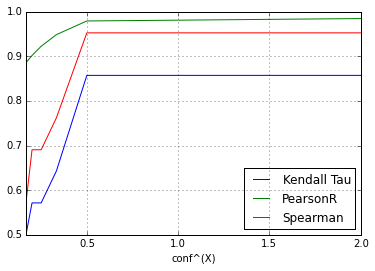

In [624]:
met.plot()
pass

# Pipeline, crime

Results of this analysis, run in a separate pipeline.

## Xformed inst.

In [121]:
sto = pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/crime/pow/1st/q/seencars/seencars.h5','r')
print sto
k = 'orig/drives'
#k = '/exp/m000500/drives'
scr = sto[k]
pprint.pprint(sto.get_storer(k).attrs.info)
sto.close()
scr

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/crime/pow/1st/q/seencars/seencars.h5
/exp/m000010/drives            frame        (shape->[5,3])
/exp/m000010/sawcar            frame        (shape->[4,3])
/exp/m000020/drives            frame        (shape->[5,3])
/exp/m000020/sawcar            frame        (shape->[4,3])
/exp/m000050/drives            frame        (shape->[5,3])
/exp/m000050/sawcar            frame        (shape->[4,3])
/exp/m000100/drives            frame        (shape->[5,3])
/exp/m000100/sawcar            frame        (shape->[4,3])
/exp/m000200/drives            frame        (shape->[5,3])
/exp/m000200/sawcar            frame        (shape->[4,3])
/exp/m000500/drives            frame        (shape->[5,3])
/exp/m000500/sawcar            frame        (shape->[4,3])
/exp/m000666/drives            frame        (shape->[5,3])
/exp/m000666/sawcar            frame        (shape->[4,3])
/exp/m000833/drives            frame        (shape

,person,car,conf
0,Jim,Honda,1.0
1,Hank,Toyota,0.6
2,Jim,Toyota,0.3
3,Bob,Toyota,0.5
4,Bob,Mazda,0.3


## Query results

In [135]:
with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/crime/pow/1st/q/seencars/qres/seencars.h5','r') as sto:
    print sto
    #k = sto.keys()[0]
    k = 'exp/m000200'
    scr = sto[k]
    pprint.pprint(sto.get_storer(k).attrs.info)
scr

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/crime/pow/1st/q/seencars/qres/seencars.h5
/exp/m000010            frame        (shape->[8,2])
/exp/m000020            frame        (shape->[8,2])
/exp/m000050            frame        (shape->[8,2])
/exp/m000100            frame        (shape->[8,2])
/exp/m000200            frame        (shape->[8,2])
/exp/m000500            frame        (shape->[8,2])
/exp/m000666            frame        (shape->[8,2])
/exp/m000833            frame        (shape->[8,2])
/exp/m001000            frame        (shape->[8,2])
/exp/m001200            frame        (shape->[8,2])
/exp/m001500            frame        (shape->[8,2])
/exp/m002000            frame        (shape->[8,2])
/exp/m005000            frame        (shape->[8,2])
/exp/m010000            frame        (shape->[8,2])
/exp/m020000            frame        (shape->[8,2])
/exp/m050000            frame        (shape->[8,2])
/exp/m100000            frame        (s

,conf,tuple
0,1.000000,"(Jim,Honda,Susan)"
1,0.400000,"(Jim,Honda,Jane)?"
2,0.632016,"(Hank,Toyota,Mary)?"
3,0.451440,"(Hank,Toyota,Jane)?"
4,0.550202,"(Jim,Toyota,Mary)?"
5,0.393002,"(Jim,Toyota,Jane)?"
6,0.609386,"(Bob,Toyota,Mary)?"
7,0.435275,"(Bob,Toyota,Jane)?"


## Comp. results

### pow1st

In [127]:
with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/crime/pow/1st/q/seencars/qres/cmp/seencars.h5','r') as sto:
    print sto
    k = sto.keys()[0]
    #k = 'exp/m000200'
    scr = sto[k]
    pprint.pprint(sto.get_storer(k).attrs.info)
scr

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/crime/pow/1st/q/seencars/qres/cmp/seencars.h5
/comparison            frame        (shape->[17,3])
{'create': 'create trio table SAWCAR(witness varchar(32),\ncar varchar(32), uncertain(car)) with confidences;\n',
 'insert': "insert into SAWCAR values [('%s','%s'):%f];",
 'qcfg': {'create': 'create table seencars as\nselect drives.person as suspect, drives.car, witness from drives, sawcar\nwhere drives.car = sawcar.car;\n',
          'query': 'select * from seencars',
          'relations': {'drives': {'create': 'create trio table DRIVES(person varchar(32),\ncar varchar(32), uncertain(person, car))\nwith confidences;\n',
                                   'insert': "insert into DRIVES values [('%s','%s'):%f];"},
                        'sawcar': {'create': 'create trio table SAWCAR(witness varchar(32),\ncar varchar(32), uncertain(car)) with confidences;\n',
                                   'insert': 

kendall   pearson  spearman
numerator denominator                              
1.0       100.0        0.500000  0.774288  0.571429
          50.0         0.500000  0.783340  0.571429
          20.0         0.500000  0.808776  0.571429
          10.0         0.500000  0.845704  0.571429
          5.0          0.571429  0.901688  0.690476
          2.0          0.857143  0.978993  0.952381
          1.5          0.928571  0.993002  0.976190
          1.2          1.000000  0.998643  1.000000
          1.0          1.000000  1.000000  1.000000
1.2       1.0          0.928571  0.998762  0.976190
1.5       1.0          0.928571  0.994242  0.976190
2.0       1.0          0.857143  0.984433  0.952381
5.0       1.0          0.857143  0.940938  0.952381
10.0      1.0          0.857143  0.926547  0.952381
20.0      1.0          0.836502  0.925366  0.946125
50.0      1.0          0.576557  0.925359  0.654654
100.0     1.0          0.576557  0.925359  0.654654

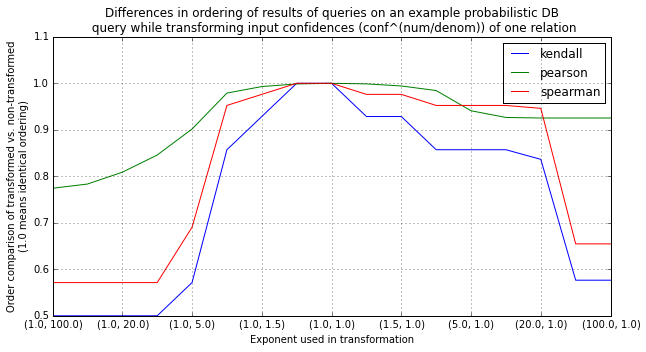

In [134]:
plt.figure(figsize=(10,5))
ax = plt.gca()
scr.plot(ax = ax)
plt.title('Differences in ordering of results of queries on an example probabilistic DB\n query while transforming input confidences (conf^(num/denom)) of one relation')
plt.xlabel('Exponent used in transformation')
plt.ylabel('Order comparison of transformed vs. non-transformed\n(1.0 means identical ordering)')
pass

### powall

In [136]:
with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/crime/pow/all/q/seencars/qres/cmp/seencars.h5','r') as sto:
    print sto
    k = sto.keys()[0]
    #k = 'exp/m000200'
    scr = sto[k]
    pprint.pprint(sto.get_storer(k).attrs.info)
scr

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/crime/pow/all/q/seencars/qres/cmp/seencars.h5
/comparison            frame        (shape->[17,3])
{'create': 'create trio table SAWCAR(witness varchar(32),\ncar varchar(32), uncertain(car)) with confidences;\n',
 'insert': "insert into SAWCAR values [('%s','%s'):%f];",
 'qcfg': {'create': 'create table seencars as\nselect drives.person as suspect, drives.car, witness from drives, sawcar\nwhere drives.car = sawcar.car;\n',
          'query': 'select * from seencars',
          'relations': {'drives': {'create': 'create trio table DRIVES(person varchar(32),\ncar varchar(32), uncertain(person, car))\nwith confidences;\n',
                                   'insert': "insert into DRIVES values [('%s','%s'):%f];"},
                        'sawcar': {'create': 'create trio table SAWCAR(witness varchar(32),\ncar varchar(32), uncertain(car)) with confidences;\n',
                                   'insert': 

kendall   pearson  spearman
numerator denominator                              
1.0       100.0        1.000000  0.954417  1.000000
          50.0         1.000000  0.955440  1.000000
          20.0         1.000000  0.958395  1.000000
          10.0         1.000000  0.963088  1.000000
          5.0          1.000000  0.971580  1.000000
          2.0          1.000000  0.989940  1.000000
          1.5          1.000000  0.995819  1.000000
          1.2          1.000000  0.999030  1.000000
          1.0          1.000000  1.000000  1.000000
1.2       1.0          1.000000  0.998841  1.000000
1.5       1.0          1.000000  0.993874  1.000000
2.0       1.0          1.000000  0.981773  1.000000
5.0       1.0          1.000000  0.941408  1.000000
10.0      1.0          1.000000  0.937182  1.000000
20.0      1.0          0.718132  0.937131  0.756323
50.0      1.0          0.500000  0.937131  0.577350
100.0     1.0          0.500000  0.937131  0.577350

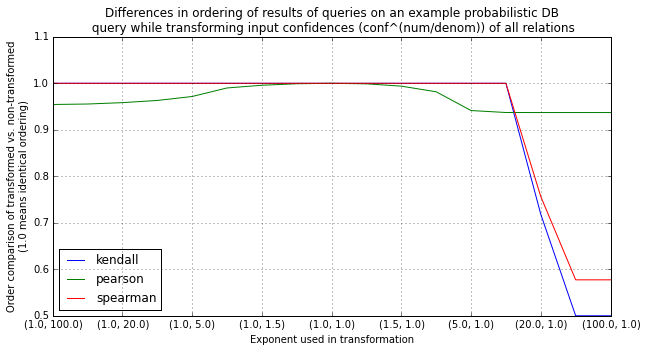

In [138]:
plt.figure(figsize=(10,5))
ax = plt.gca()
scr.plot(ax = ax)
plt.title('Differences in ordering of results of queries on an example probabilistic DB\n query while transforming input confidences (conf^(num/denom)) of all relations')
plt.xlabel('Exponent used in transformation')
plt.ylabel('Order comparison of transformed vs. non-transformed\n(1.0 means identical ordering)')
pass

# Pipeline, TPC-H

In [112]:
#scr = pd.read_csv('/home/amemory/Data/prdbsens/pipelines/tpch/rel/region_r.csv',quotechar="'")
#scr = pd.read_csv('/home/amemory/Data/prdbsens/pipelines/tpch/rel/nation_n.csv',quotechar="'")
scr = pd.read_csv('/home/amemory/Data/prdbsens/pipelines/tpch/rel/cust_c.csv',quotechar="'")
#scr = pd.read_csv('/home/amemory/Data/prdbsens/pipelines/tpch/rel/orders_o.csv',quotechar="'")
print len(scr)

200848


In [113]:
scr.head(2)

,custkey,name,acctbal,address,mktsegment,nationkey,phone,comment,conf
0,1,Customer#000000001,711.56,"IVhzIApeRb ot,c,E",BUILDING,15,25-989-741-2988,"to the even, regular platelets. regular, ironi...",0.5
1,1,Customer#000087131,8761.57,"pddnCHIRd,eXnrf",FURNITURE,12,22-874-145-6560,"e special, even pinto beans. finally even pack...",0.5


In [114]:
scr2 = pd.read_csv('/home/amemory/Data/prdbsens/pipelines/tpch/rel/sam/20000/cust_c.csv',quotechar="'")
len(scr2)

20000

In [115]:
scr2.head(2)

,custkey,name,acctbal,address,mktsegment,nationkey,phone,comment,conf
0,110515,Customer#000110515,783.22,o7G7R4orbpwK828o6J5EDpbdt0gQ,MACHINERY,18,28-195-863-5902,pinto beans run quickly according to the depos...,1.0000
1,125331,Customer#000125331,3904.37,oPrxksMlgoerB5GEeQIbr2kQL3u5x0iwh,BUILDING,21,31-795-444-4855,wake quickly furiously busy packages. bold req...,0.3333


In [95]:
scr.dtypes

custkey         int64
name           object
acctbal       float64
address        object
mktsegment     object
nationkey       int64
phone          object
comment        object
conf          float64
dtype: object

In [96]:
# scr['comment'] = scr.comment.str.replace(';',' ')

In [97]:
scr = scr.apply(lambda c: c.str.replace(';',' '), axis=1)

In [91]:
len(scr)

123

In [92]:
scr.iloc[122].comment

's are quickly above the quickly ironic instructions  even requests about the carefully final deposi'

In [99]:
scr.head(2)

,custkey,name,acctbal,address,mktsegment,nationkey,phone,comment,conf
0,NaN,Customer#000000001,NaN,"IVhzIApeRb ot,c,E",BUILDING,NaN,25-989-741-2988,"to the even, regular platelets. regular, ironi...",NaN
1,NaN,Customer#000087131,NaN,"pddnCHIRd,eXnrf",FURNITURE,NaN,22-874-145-6560,"e special, even pinto beans. finally even pack...",NaN


In [98]:
scr.dtypes

custkey       float64
name           object
acctbal       float64
address        object
mktsegment     object
nationkey     float64
phone          object
comment        object
conf          float64
dtype: object

## Inst., tpch

In [22]:
with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy001_reg_nat/toy001_reg_nat.h5','r') as sto:
    print sto
    #k = sto.keys()[0]
    #k = 'exp/m000500/nation_n'
    k = 'orig/nation_n'
    scr = sto[k]
    #pprint.pprint(sto.get_storer(k).attrs.info)
scr.head(2)

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy001_reg_nat/toy001_reg_nat.h5
/exp/m000500/nation_n            frame        (shape->[28,5])
/exp/m000500/region_r            frame        (shape->[5,4]) 
/orig/nation_n                   frame        (shape->[28,5])
/orig/region_r                   frame        (shape->[5,4]) 


,nationkey,name,regionkey,comment,conf
0,0,ALGERIA,0,haggle. carefully final deposits detect slyly ...,1
1,1,ARGENTINA,1,al foxes promise slyly according to the regula...,1


## Res., tpch

In [100]:
#with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy001_reg_nat/qres/toy001_reg_nat.h5','r') as sto:
with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy002_cust_ord/qres/toy002_cust_ord.h5','r') as sto:
    print sto
    #k = sto.keys()[0]
    k = 'orig'
    scr = sto[k]
    k = 'exp/m000500'
    scrt = sto[k]
    #pprint.pprint(sto.get_storer(k).attrs.info)
scr.head(2)

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy002_cust_ord/qres/toy002_cust_ord.h5
/exp/m000500            frame        (shape->[5,2])
/orig                   frame        (shape->[5,2])


,conf,tuple
0,1,"(18527,1993-02-15 00:00:00,0,Customer#000001955)"
1,1,"(34567,1992-04-24 00:00:00,0,Customer#000001468)"


In [101]:
print len(scr)
scr.head(2)

5


,conf,tuple
0,1,"(18527,1993-02-15 00:00:00,0,Customer#000001955)"
1,1,"(34567,1992-04-24 00:00:00,0,Customer#000001468)"


In [102]:
print len(scrt)
scrt.head(2)

5


,conf,tuple
0,1,"(18527,1993-02-15 00:00:00,0,Customer#000001955)"
1,1,"(34567,1992-04-24 00:00:00,0,Customer#000001468)"


In [103]:
#scrm = scr.join(scrt)

In [104]:
scrm= scr.merge(scrt, on='tuple')
print len(scrm)
scrm.head(2)

5


,conf_x,tuple,conf_y
0,1,"(18527,1993-02-15 00:00:00,0,Customer#000001955)",1
1,1,"(34567,1992-04-24 00:00:00,0,Customer#000001468)",1


In [105]:
scr.tuple.value_counts()

(34567,1992-04-24 00:00:00,0,Customer#000001468)     1
(83683,1994-04-20 00:00:00,0,Customer#000000931)     1
(36072,1992-05-10 00:00:00,0,Customer#000001714)     1
(69304,1994-07-24 00:00:00,0,Customer#000002034)?    1
(18527,1993-02-15 00:00:00,0,Customer#000001955)     1
dtype: int64

In [106]:
scrt.tuple.value_counts()

(34567,1992-04-24 00:00:00,0,Customer#000001468)     1
(83683,1994-04-20 00:00:00,0,Customer#000000931)     1
(36072,1992-05-10 00:00:00,0,Customer#000001714)     1
(69304,1994-07-24 00:00:00,0,Customer#000002034)?    1
(18527,1993-02-15 00:00:00,0,Customer#000001955)     1
dtype: int64

In [107]:
scrm.tuple.value_counts()

(34567,1992-04-24 00:00:00,0,Customer#000001468)     1
(83683,1994-04-20 00:00:00,0,Customer#000000931)     1
(36072,1992-05-10 00:00:00,0,Customer#000001714)     1
(69304,1994-07-24 00:00:00,0,Customer#000002034)?    1
(18527,1993-02-15 00:00:00,0,Customer#000001955)     1
dtype: int64

## Comp., tpch

### toy001_reg_nat

In [126]:
with open('/home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy001_reg_nat.yaml','r') as f:
    qcfg = yaml.load(f)
    print "CREATE"
    print(qcfg['create'])    
    print "QUERY"
    print(qcfg['query'])

CREATE
create table reg_nat as
select distinct nation_n.name as nation, region_r.name as region
from nation_n, region_r
where nation_n.regionkey = region_r.regionkey;

QUERY
select * from reg_nat


In [120]:
with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy001_reg_nat/qres/cmp/toy001_reg_nat.h5','r') as sto:
    print sto
    k = sto.keys()[0]
    scr = sto[k]
    #pprint.pprint(sto.get_storer(k).attrs.info)
scr.head(2)

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy001_reg_nat/qres/cmp/toy001_reg_nat.h5
/comparison            frame        (shape->[7,3])


kendall   pearson  spearman
numerator denominator                              
1         50           0.953488  0.665622  0.995868
          20           0.953488  0.721279  0.995868

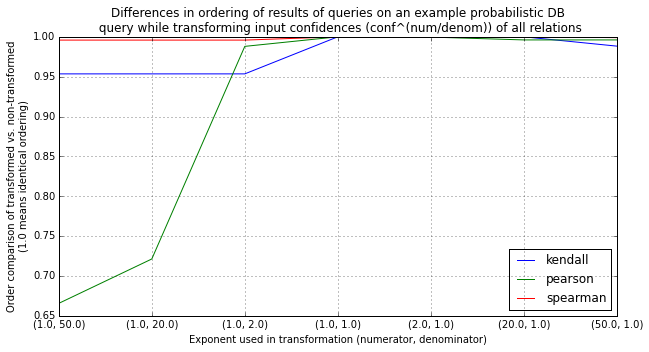

In [121]:
plt.figure(figsize=(10,5))
ax = plt.gca()
scr.plot(ax = ax)
plt.title('Differences in ordering of results of queries on an example probabilistic DB\n query while transforming input confidences (conf^(num/denom)) of all relations')
plt.xlabel('Exponent used in transformation (numerator, denominator)')
plt.ylabel('Order comparison of transformed vs. non-transformed\n(1.0 means identical ordering)')
pass

### toy002_cust_ord

In [127]:
with open('/home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy002_cust_ord.yaml','r') as f:
    qcfg = yaml.load(f)
    print "CREATE"
    print(qcfg['create'])    
    print "QUERY"
    print(qcfg['query'])

CREATE
create table cust_ord as
select distinct
orders_o.orderkey as orderkey,
orders_o.orderdate as orderdate,
orders_o.shippriority as shippriority,
cust_c.name as customer
from orders_o, cust_c
where cust_c.mktsegment = 'BUILDING'
and orders_o.custkey = cust_c.custkey
and orders_o.orderdate < '1995-03-15';

QUERY
select * from cust_ord


In [117]:
with pd.HDFStore('/home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy002_cust_ord/qres/cmp/toy002_cust_ord.h5','r') as sto:
    print sto
    k = sto.keys()[0]
    #k = 'exp/m000200'
    scr = sto[k]
    pprint.pprint(sto.get_storer(k).attrs.info)
scr

<class 'pandas.io.pytables.HDFStore'>
File path: /home/amemory/Data/prdbsens/pipelines/tpch/pow/all/q/toy002_cust_ord/qres/cmp/toy002_cust_ord.h5
/comparison            frame        (shape->[7,3])
{'create': 'create trio table orders_o(\norderkey int,\ncustkey int,\norderstatus varchar(1),\ntotalprice float,\norderdate varchar(40),\norderpriority varchar(15),\nshippriority int,\nclerk varchar(15),\ncomment varchar(79),\nuncertain(\ncustkey,\norderstatus,\ntotalprice,\norderdate,\norderpriority,\nshippriority,\nclerk,\ncomment\n))\nwith confidences;\n',
 'insert': "insert into orders_o values [(%d,%d,'%s',%f,'%s','%s',%d,'%s','%s'):%f];",
 'qcfg': {'create': "create table cust_ord as\nselect distinct\norders_o.orderkey as orderkey,\norders_o.orderdate as orderdate,\norders_o.shippriority as shippriority,\ncust_c.name as customer\nfrom orders_o, cust_c\nwhere cust_c.mktsegment = 'BUILDING'\nand orders_o.custkey = cust_c.custkey\nand orders_o.orderdate < '1995-03-15';\n",
          'query

kendall   pearson  spearman
numerator denominator                              
1         50           0.961735  0.866805  0.986259
          20           0.961735  0.880692  0.986259
          2            0.979568  0.985056  0.995526
          1            1.000000  1.000000  1.000000
2         1            0.992562  0.989682  0.999467
20        1            0.873739  0.966468  0.951114
50        1            0.819436  0.966468  0.919057

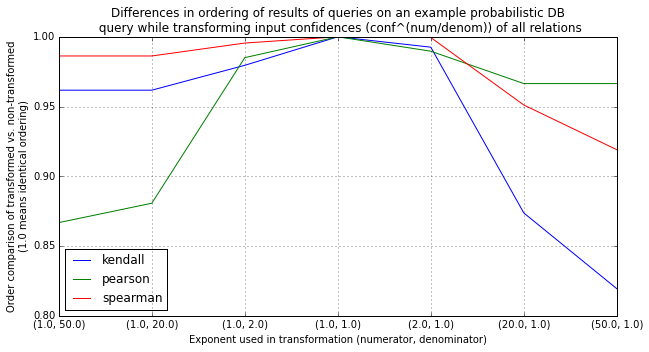

In [119]:
plt.figure(figsize=(10,5))
ax = plt.gca()
scr.plot(ax = ax)
plt.title('Differences in ordering of results of queries on an example probabilistic DB\n query while transforming input confidences (conf^(num/denom)) of all relations')
plt.xlabel('Exponent used in transformation (numerator, denominator)')
plt.ylabel('Order comparison of transformed vs. non-transformed\n(1.0 means identical ordering)')
pass